In [113]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [114]:
print(f'Length of the text in charaters: {len(text)}')

Length of the text in charaters: 1115393


In [115]:
n = 1000
print(f'First {n} characters:\n{text[:n]}')

First 1000 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not i

#### Building of the vocabulary based on the given dataset

In [116]:
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print(f'Vocabulary: {"".join(vocab)}')
print(f'Vocabulary size: {vocab_size}')

Vocabulary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65


#### Mapping of the characters to integers

In [117]:
ctoi = {c:i for i,c in enumerate(vocab)}
itoc = {i:c for i,c in enumerate(vocab)}
encode = lambda s: [ctoi[c] for c in s]
decode = lambda l: [itoc[i] for i in l]

In [118]:
sample_text = 'sample text'
print(f'Sample text: {sample_text}')
print(f'Encoding example: {encode(sample_text)}')
print(f'Decoding example: {"".join(decode(encode(sample_text)))}')

Sample text: sample text
Encoding example: [57, 39, 51, 54, 50, 43, 1, 58, 43, 62, 58]
Decoding example: sample text


##### Encoding of the entire dataset

In [119]:
import torch
data = torch.tensor(encode(text))
print(f'Data tensor shape: {data.shape}')
print(f'Data tensor content (first 50 elements): {data[:50]}')

Data tensor shape: torch.Size([1115393])
Data tensor content (first 50 elements): tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56])


#### Splitting of the dataset (training & validation)

In [120]:
train_split = 0.9
train_count = int(train_split * len(data))
train_data = data[:train_count]
val_data = data[train_count:]
print(f'Characters in training set: {len(train_data)}')
print(f'Characters in validation set: {len(val_data)}')

Characters in training set: 1003853
Characters in validation set: 111540


#### Structuring of the data splits into blocks

In [121]:
block_size = 8
block_sample_train = train_data[:block_size+1]
print(f'Sample block from training set: {block_sample_train}')

Sample block from training set: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])


#### Structuring of the blocks into batches

In [122]:
torch.manual_seed(1234)
batch_size = 4
block_size = 8

def get_batch(data, batch_size, block_size):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [123]:
xb, yb = get_batch(data, batch_size, block_size)
print(f'Sample training batch X shape: {xb.shape}')
print(f'Sample training batch Y shape: {yb.shape}')
print(f'Sample training batch X:\n {xb}')
print(f'Sample training batch Y:\n {yb}')
print(f'Sample training batch X (decoded):\n {["".join(decode(x)) for x in xb.tolist()]}')
print(f'Sample training batch Y (decoded):\n {["".join(decode(y)) for y in yb.tolist()]}')

Sample training batch X shape: torch.Size([4, 8])
Sample training batch Y shape: torch.Size([4, 8])
Sample training batch X:
 tensor([[21, 17, 32, 10,  0, 27,  1, 58],
        [ 6,  1, 44, 53, 53, 50, 47, 57],
        [43, 56,  2,  1, 39, 58,  1, 39],
        [53, 59, 56,  1, 43, 63, 43, 57]])
Sample training batch Y:
 tensor([[17, 32, 10,  0, 27,  1, 58, 46],
        [ 1, 44, 53, 53, 50, 47, 57, 46],
        [56,  2,  1, 39, 58,  1, 39,  1],
        [59, 56,  1, 43, 63, 43, 57,  1]])
Sample training batch X (decoded):
 ['IET:\nO t', ', foolis', 'er! at a', 'our eyes']
Sample training batch Y (decoded):
 ['ET:\nO th', ' foolish', 'r! at a ', 'ur eyes ']


#### Definition of a simple Bigram Language Model

In [124]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=vocab_size)
        
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(input=logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

##### Sample inference through the Bigram Language Model

In [125]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(f'Sample batch logits shape: {logits.shape}')

Sample batch logits shape: torch.Size([32, 65])


##### Sample generation of tokens using the Bigram Language Model

In [126]:
idx_start = torch.zeros(size=(1, 1), dtype=torch.long)
idx_pred = m.generate(idx=idx_start, max_new_tokens=50)
idx_pred_decoded = decode(idx_pred[0].tolist())
print(f'Starting token (input for the model): {decode(idx_start[0].tolist())}')
print(f'Generated tokens: {"".join(idx_pred_decoded)}')

Starting token (input for the model): ['\n']
Generated tokens: 
Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLER


##### Optimization of the Bigram Language Model

In [127]:
batch_size = 32
block_size = 8
lr = 1e-3
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)
for step in range(1000):
    xb, yb = get_batch(train_data, batch_size, block_size)
    logits, loss = m(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(f'Loss after training: {loss.item()}')

Loss after training: 3.794015884399414


In [128]:
idx_start = torch.zeros(size=(1, 1), dtype=torch.long)
idx_pred = m.generate(idx=idx_start, max_new_tokens=50)
idx_pred_decoded = decode(idx_pred[0].tolist())
print(f'Starting token (input for the model): {decode(idx_start[0].tolist())}')
print(f'Generated tokens: {"".join(idx_pred_decoded)}')

Starting token (input for the model): ['\n']
Generated tokens: 
C xtRjRy!
SAAd.
wDWCASlvirTOq-onAGj;pJFq,Sb?suArdl


#### Building up the self-attention mechanism (toy example)

##### Weighted aggregation through matrix multiplication

In [129]:
torch.manual_seed(1234)
block_size = 8
a = torch.tril(input=torch.ones(block_size, block_size))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(low=0, high=10, size=(block_size, 4)).float()
c = a @ b
print(f'Mask matrix:\n {a}')
print(f'Input matrix:\n {b}')
print(f'Multiplication result matrix:\n {c}')

Mask matrix:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
Input matrix:
 tensor([[5., 1., 6., 5.],
        [6., 4., 2., 5.],
        [5., 9., 3., 1.],
        [4., 2., 3., 2.],
        [6., 8., 2., 2.],
        [8., 2., 0., 4.],
        [9., 2., 1., 9.],
        [2., 2., 9., 4.]])
Multiplication result matrix:
 tensor([[5.0000, 1.0000, 6.0000, 5.0000],
        [5.5000, 2.5000, 4.0000, 5.0000],
        [5.3333, 4.6667, 3.6667, 3.6667],
        [5.0

##### Example input initialization
For using the self-attention mechanism, a simple example batch of token sequences is constructed.

In [130]:
batch_size = 4 # Number of blocks in a batch
block_size = 8 # Number of tokens in a block (context)
channels = 2 # Number of dimensions per token embedding
B, T, C = batch_size, block_size, channels
xb = torch.randn(size=(B, T, C))
print(f'Sample batch shape: {xb.shape}')

Sample batch shape: torch.Size([4, 8, 2])


##### Version 1

In [131]:
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = xb[b, :t+1]
        xbow[b, t] = torch.mean(xprev, 0)
print(f'Bag of words shape: {xbow.shape}')

Bag of words shape: torch.Size([4, 8, 2])


##### Version 2 (basic normalization)

In [132]:
wei = torch.tril(input=torch.ones(size=(T, T)))
wei = wei / wei.sum(1, keepdim=True)
xbow_v2 = wei @ xb
print(f'Output similar to previous version: {torch.allclose(input=xbow_v2, other=xbow)}')

Output similar to previous version: True


##### Version 3 (softmax)

In [133]:
tril = torch.tril(input=torch.ones(size=(T, T)))
wei = torch.zeros(size=(T, T))
wei = torch.masked_fill(wei, tril == 0, float('-inf'))
wei = F.softmax(input=wei, dim=-1)
xbow_v3 = wei @ xb
print(f'Output similar to previous version: {torch.allclose(input=xbow_v3, other=xbow_v2)}')

Output similar to previous version: True


##### Version 4 (attention)

In [134]:
attention_head_size = 16
query_layer = nn.Linear(in_features=C, out_features=attention_head_size, bias=False)
key_layer = nn.Linear(in_features=C, out_features=attention_head_size, bias=False)
value_layer = nn.Linear(in_features=C, out_features=attention_head_size, bias=False)
query = query_layer(xb) # (B, T, C) = (4, 8, 16)
key = key_layer(xb) # (B, T, C) = (4, 8, 16)
wei = query @ key.transpose(-2, -1)
tril = torch.tril(input=torch.ones(size=(T, T)))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(input=wei, dim=-1) # (B, T, T) = (4, 8, 8)
value = value_layer(xb)
out = wei @ value
print(f'Output shape: {out.shape}')
print(f'Output content (0th batch):\n {out[0]}')

Output shape: torch.Size([4, 8, 16])
Output content (0th batch):
 tensor([[-0.4551, -0.5526,  0.4067,  0.2550, -0.3048, -0.1731, -0.5725,  0.1139,
          0.2080,  0.5886,  1.4262,  0.2830,  0.5163, -0.3095, -1.2823, -0.7509],
        [-0.5679, -0.4652,  0.6511,  0.4457, -0.3853,  0.0788, -0.7776, -0.2069,
          0.3766,  0.5696,  1.0918,  0.1085,  0.5189, -0.2046, -1.0626, -0.4917],
        [-0.5463, -0.3222,  0.7065,  0.4998, -0.3733,  0.2403, -0.7833, -0.3939,
          0.4276,  0.4559,  0.6663, -0.0323,  0.4292, -0.0954, -0.7220, -0.2245],
        [-0.5706, -0.2554,  0.7897,  0.5681, -0.3917,  0.3576, -0.8409, -0.5376,
          0.4890,  0.4165,  0.4470, -0.1222,  0.4029, -0.0340, -0.5596, -0.0734],
        [-0.5796, -0.3815,  0.7242,  0.5078, -0.3952,  0.2029, -0.8199, -0.3562,
          0.4330,  0.5128,  0.8284,  0.0090,  0.4775, -0.1333, -0.8610, -0.3168],
        [-0.6588, -0.5004,  0.7804,  0.5392, -0.4477,  0.1429, -0.9131, -0.3010,
          0.4574,  0.6319,  1.1462,  0

##### Scaled attention (illustrative example)

Unscaled softmax: tensor([0.0695, 0.1548, 0.0028, 0.7666, 0.0063])
Scaled softmax: tensor([0.2055, 0.2271, 0.1378, 0.2774, 0.1522])


C:\Users\Manuel\AppData\Local\Temp\ipykernel_37388\2547081506.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  ax[0].set_yticks(torch.range(start=0.0, end=1.0, step=0.1))
C:\Users\Manuel\AppData\Local\Temp\ipykernel_37388\2547081506.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  ax[1].set_yticks(torch.range(start=0.0, end=1.0, step=0.1))
C:\Users\Manuel\AppData\Local\Temp\ipykernel_37388\2547081506.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


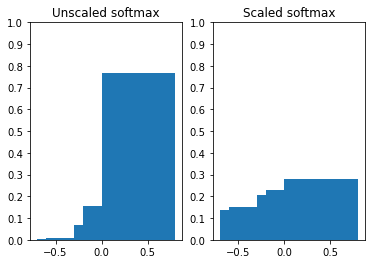

In [138]:
import matplotlib.pyplot as plt
vector = [0.1, 0.2, -0.3, 0.4, -0.2]
vector_scaled_softmax = torch.softmax(torch.tensor(vector), dim=-1)
vector_unscaled_softmax = torch.softmax(torch.tensor(vector)*8, dim=-1)
print(f'Unscaled softmax: {vector_unscaled_softmax}')
print(f'Scaled softmax: {vector_scaled_softmax}')
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].bar(x=vector, height=vector_unscaled_softmax.tolist())
ax[1].bar(x=vector, height=vector_scaled_softmax.tolist())
ax[0].set_yticks(torch.range(start=0.0, end=1.0, step=0.1))
ax[1].set_yticks(torch.range(start=0.0, end=1.0, step=0.1))
ax[0].set_title('Unscaled softmax')
ax[1].set_title('Scaled softmax')
fig.show()

#### Defining components for building a decoder-only transformer

##### Layer normalization operation (LN)
- Used to normalized the activations of a layer, across the entire layer, **independently for each example in a batch**
- LN is performed by subtracting the mean from and dividing the activations by the standard deviation, computed across the **feature dimension** 

In [141]:
class LayerNorm1d:
    def __init__(self, dim, epsilon=1e-5, momentum=0.1):
        self.epsilon = epsilon
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x: torch.Tensor):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, keepdim=True)
        normalized = (x - mean) / torch.sqrt(var + self.epsilon)
        self.out = self.gamma * normalized + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [149]:
x = torch.rand(size=(8, 4))
layer_norm = LayerNorm1d(dim=x.shape)
x_layer_normalized = layer_norm(x)
print(f'Standard deviation (across features):\n {x_layer_normalized.std(dim=-1, keepdim=False)}')
print(f'Mean (across features):\n {x_layer_normalized.mean(dim=-1, keepdim=False)}')

Standard deviation (across features):
 tensor([0.9999, 0.9995, 0.9998, 0.9999, 0.9998, 1.0000, 1.0000, 0.9999])
Mean (across features):
 tensor([-1.4901e-08, -1.6391e-07,  2.9802e-08, -8.9407e-08,  2.1607e-07,
        -1.4901e-08, -4.4703e-08,  6.5193e-09])


##### Transformer Decoder module

In [ ]:
import torch.nn as nn

class Head(nn.Module):
    def __init__(self, embedding_dim, head_size):
        super().__init__()
        self.query = nn.Linear(in_features=embedding_dim, out_features=head_size, bias=False)
        self.key = nn.Linear(in_features=embedding_dim, out_features=head_size, bias=False)
        self.value = nn.Linear(in_features=embedding_dim, out_features=head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input):
        _, T, _ = input.shape
        q = self.query(input)
        k = self.key(input)
        v = self.value(input)
        wei = q @ k.transpose(-2, -1) * (k.shape[-1]**-0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = torch.softmax(input=wei, dim=-1)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embedding_dim):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(in_features=num_heads*head_size, out_features=embedding_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input):
        out = torch.cat([head(input) for head in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.ReLU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )

    def forward(self, input):
        return self.net(input)

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.head_size = embedding_dim // num_heads
        self.self_attention = MultiHeadAttention(num_heads, self.head_size, embedding_dim)
        self.feed_forward = FeedForward(embedding_dim)
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, input):
        out = input + self.self_attention(self.layer_norm1(input))
        out = out + self.feed_forward(self.layer_norm1(out))
        return out

class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, num_embeddings, embedding_dim, num_heads, block_size, vocab_size):
        super().__init__()

    def forward(self, input):
        pass

    def generate(self, input):
        pass
